In [1]:
# ============================================
# Useful Imports
# ============================================

# --- Standard Libraries
import os
import time
import math
import random
from collections import Counter

# --- Core Data / Numerics
import numpy as np
import pandas as pd

# --- Visualization
import matplotlib.pyplot as plt
# import seaborn as sns              # optional
import matplotlib.ticker as mticker  # optional (for formatted axes)

# --- NLP / Tokenization
import spacy                         # used for text preprocessing (HuffPost)

# --- Progress Tracking
from tqdm import tqdm                # optional (nice for loops)

from IPython.display import display

# --- TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)

from tensorflow.keras import layers, models, Input, Sequential
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

# hugging face
# --- Hugging Face Datasets
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

# --- (Optional) Classical ML Baseline Tools
# from sklearn.pipeline import Pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score


# ============================================
# Global Configuration & Small Utilities
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)   # sets Python, NumPy, and TensorFlow seeds

# Utility: format seconds as HH:MM:SS

"""
Example usage to time your code:

start_time = time.time()
# ... your code here ...
print("Execution Time:", format_hms(time.time() - start_time))
"""

def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# load dataset
from datasets import load_from_disk
print("loading huffpost dataset")
huff_all = load_from_disk("huffpost_splits")  # reload when needed

2025-12-03 08:58:06.341754: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 08:58:06.491084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 08:58:07.381319: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


loading huffpost dataset


### Key Learnings
1. Pretrained transformers dramatically outperform training-from-scratch approaches
2. Class imbalance significantly impacts minority class performance
3. Overlapping categories (e.g., "ARTS" vs "ARTS & CULTURE" vs "CULTURE & ARTS") cause confusion

---

## Improvements for Final Model

Based on Milestone 2 error analysis, we implement:

1. **Expanded Class Consolidation** - Merge semantically similar/duplicate categories
2. **Easy Data Augmentation (EDA)** - Augment minority classes to reduce imbalance
3. **Refined Training Strategy** - Optimized hyperparameters based on M2 results

In [2]:
# ============================================
# A.1: COMPLETE PREPROCESSING PIPELINE
# ============================================
# This cell handles the entire data preparation flow:
# 1. Load raw data
# 2. Clean and combine text fields
# 3. Consolidate overlapping categories
# 4. Stratified train/val/test split
# 5. EDA + Back-translation augmentation on minority classes
# 6. Tokenization with DistilBERT
# 7. Label encoding and class weights

import numpy as np
import pandas as pd
import random
import pickle
import os
import time
from tqdm import tqdm
from collections import Counter

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict, load_from_disk
from transformers import AutoTokenizer, MarianMTModel, MarianTokenizer

# For EDA augmentation
import nlpaug.augmenter.word as naw

print("=" * 70)
print("A.1: PREPROCESSING PIPELINE")
print("=" * 70)

# ============================================
# CONFIGURATION
# ============================================

CONFIG = {
    'random_seed': 42,
    'max_length': 128,
    'test_size': 0.30,          # 30% held out for val+test
    'val_test_ratio': 0.50,     # Split held-out 50/50 into val and test
    'model_name': 'distilbert-base-uncased',

    # EDA Configuration (reduced to help with overfitting)
    'eda_min_class_size': 5000,   # Augment classes smaller than this
    'eda_num_augmentations': 1,   # Reduced from 2 to help with overfitting
    'eda_aug_probability': 0.15,  # Slightly more aggressive changes

    # Back-translation Configuration
    'use_backtranslation': True,  # Higher quality augmentation
    'backtrans_lang': 'De',       # Language for back-translation (German)
    
    # Caching - skip augmentation if cached file exists
    'augmented_cache_file': 'train_augmented_backtrans.parquet',
}

# Set random seeds for reproducibility
random.seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

# ============================================
# CLASS CONSOLIDATION MAPPING
# ============================================
# Based on Milestone 2 confusion matrix analysis, merge semantically 
# similar or duplicate categories to create cleaner decision boundaries.

CLASS_MERGE_MAP = {
    # Exact duplicates / naming variations
    'ARTS': 'ARTS & CULTURE',
    'CULTURE & ARTS': 'ARTS & CULTURE',

    # Environmental content
    'GREEN': 'ENVIRONMENT',

    # World news variations  
    'WORLDPOST': 'WORLD NEWS',
    'THE WORLDPOST': 'WORLD NEWS',

    # Style/fashion
    'STYLE': 'STYLE & BEAUTY',

    # Parenting
    'PARENTS': 'PARENTING',

    # Food content
    'TASTE': 'FOOD & DRINK',

    # Health/wellness overlap (these had high confusion in M2)
    'HEALTHY LIVING': 'WELLNESS',
}

# ============================================
# STEP 1: LOAD RAW DATA
# ============================================
print("\n[1/7] Loading raw dataset...")

huff_all = load_from_disk("huffpost_splits")

def combine_fields(example):
    """Combine headline and short_description into single text field."""
    headline = example.get('headline', '') or ""
    short_desc = example.get('short_description', '') or "[NO_DESC]"
    example['text'] = f"{headline} [SEP] {short_desc}"
    return example

huff_all = huff_all.map(combine_fields)
df_raw = huff_all.to_pandas()
print(f"  Loaded {len(df_raw):,} samples")
print(f"  Original categories: {df_raw['category'].nunique()}")

# ============================================
# STEP 2: BASIC CLEANING
# ============================================
print("\n[2/7] Cleaning data...")

df = df_raw.copy()

# Handle missing values
df['headline'] = df['headline'].fillna('')
df['short_description'] = df['short_description'].fillna('[NO_DESC]')
df['text'] = df['headline'] + " [SEP] " + df['short_description']

# Remove duplicates
original_len = len(df)
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)
print(f"  Removed {original_len - len(df):,} duplicates")
print(f"  Remaining samples: {len(df):,}")

# ============================================
# STEP 3: CLASS CONSOLIDATION
# ============================================
print("\n[3/7] Consolidating overlapping categories...")

original_classes = df['category'].nunique()
df['category'] = df['category'].replace(CLASS_MERGE_MAP)
new_classes = df['category'].nunique()

print(f"  {original_classes} -> {new_classes} classes")
print(f"  Merged {original_classes - new_classes} redundant categories")

# Show new distribution
print("\n  Class distribution (top 10):")
for cat, count in df['category'].value_counts().head(10).items():
    print(f"    {cat}: {count:,}")

# ============================================
# STEP 4: STRATIFIED TRAIN/VAL/TEST SPLIT
# ============================================
print("\n[4/7] Creating stratified splits...")

train_df, temp_df = train_test_split(
    df,
    test_size=CONFIG['test_size'],
    stratify=df['category'],
    random_state=CONFIG['random_seed']
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=CONFIG['val_test_ratio'],
    stratify=temp_df['category'],
    random_state=CONFIG['random_seed']
)

print(f"  Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val:   {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")

# ============================================
# STEP 5: EDA + BACK-TRANSLATION AUGMENTATION
# ============================================
print("\n[5/7] Applying augmentation to minority classes...")

# Check for cached augmented data
if os.path.exists(CONFIG['augmented_cache_file']):
    print(f"  Found cached augmented data: {CONFIG['augmented_cache_file']}")
    print(f"  Loading from cache (skipping augmentation)...")
    train_df_aug = pd.read_parquet(CONFIG['augmented_cache_file'])
    print(f"  Loaded {len(train_df_aug):,} training samples from cache")
else:
    print(f"  No cache found. Running augmentation (this may take a while)...")
    
    # --- Initialize basic EDA augmenters ---
    aug_synonym = naw.SynonymAug(aug_src='wordnet', aug_p=CONFIG['eda_aug_probability'])
    aug_swap = naw.RandomWordAug(action='swap', aug_p=CONFIG['eda_aug_probability'])
    aug_delete = naw.RandomWordAug(action='delete', aug_p=CONFIG['eda_aug_probability'])
    basic_augmenters = [aug_synonym, aug_swap, aug_delete]

    # --- Initialize back-translation models ---
    backtrans_model = None
    backtrans_tokenizer = None
    reverse_model = None
    reverse_tokenizer = None

    if CONFIG['use_backtranslation']:
        print("  Loading back-translation models (English <-> German)...")
        import torch

        # Determine device
        if torch.cuda.is_available():
            bt_device = 'cuda'
        elif torch.backends.mps.is_available():
            bt_device = 'mps'
        else:
            bt_device = 'cpu'
        print(f"  Back-translation device: {bt_device}")

        lang = CONFIG['backtrans_lang']
        # English -> Target language
        backtrans_tokenizer = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-en-{lang}')
        backtrans_model = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-en-{lang}').to(bt_device)

        # Target language -> English
        reverse_tokenizer = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-{lang}-en')
        reverse_model = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-{lang}-en').to(bt_device)

        def back_translate(text, max_length=128):
            """Translate text to target language and back to English for paraphrasing."""
            try:
                # English -> Target
                inputs = backtrans_tokenizer(text, return_tensors="pt", 
                                             padding=True, truncation=True, 
                                             max_length=max_length).to(bt_device)
                translated = backtrans_model.generate(**inputs, max_length=max_length)
                translated_text = backtrans_tokenizer.decode(translated[0], skip_special_tokens=True)

                # Target -> English
                inputs = reverse_tokenizer(translated_text, return_tensors="pt",
                                           padding=True, truncation=True,
                                           max_length=max_length).to(bt_device)
                back_translated = reverse_model.generate(**inputs, max_length=max_length)
                result = reverse_tokenizer.decode(back_translated[0], skip_special_tokens=True)

                return result
            except Exception as e:
                return text  # Fallback to original on error

    def augment_text(text, num_aug=1, use_backtrans=True):
        """
        Apply augmentation to generate variations.
        Uses mix of basic EDA and back-translation for diversity.
        """
        augmented = []

        for i in range(num_aug):
            # Alternate between back-translation and basic EDA
            if use_backtrans and backtrans_model is not None and i % 2 == 0:
                # Use back-translation for higher quality paraphrases
                aug_text = back_translate(text)
            else:
                # Use basic EDA
                aug = random.choice(basic_augmenters)
                try:
                    result = aug.augment(text)
                    if isinstance(result, list):
                        result = result[0]
                    aug_text = result
                except:
                    aug_text = text

            augmented.append(aug_text)

        return augmented

    # Identify minority classes
    class_counts = train_df['category'].value_counts()
    minority_classes = class_counts[class_counts < CONFIG['eda_min_class_size']].index.tolist()
    
    # Calculate total samples to process
    total_samples = sum(class_counts[cls] for cls in minority_classes)

    print(f"  Minority classes to augment: {len(minority_classes)}")
    print(f"  Threshold: < {CONFIG['eda_min_class_size']:,} samples")
    print(f"  Total samples to augment: {total_samples:,}")
    print(f"  Augmentations per sample: {CONFIG['eda_num_augmentations']}")
    print(f"  Back-translation enabled: {CONFIG['use_backtranslation']}")
    print()

    # Augment minority classes with detailed progress
    augmented_rows = []
    global_start = time.time()
    samples_processed = 0
    
    for cls_idx, cls in enumerate(minority_classes):
        class_samples = train_df[train_df['category'] == cls]
        class_size = len(class_samples)
        class_start = time.time()
        
        print(f"  [{cls_idx+1}/{len(minority_classes)}] {cls} ({class_size:,} samples)...", end=" ", flush=True)
        
        # Progress bar for samples within this class
        for sample_idx, (_, row) in enumerate(class_samples.iterrows()):
            aug_texts = augment_text(
                row['text'], 
                num_aug=CONFIG['eda_num_augmentations'],
                use_backtrans=CONFIG['use_backtranslation']
            )
            for aug_text in aug_texts:
                new_row = row.copy()
                new_row['text'] = aug_text
                augmented_rows.append(new_row)
            
            samples_processed += 1
            
            # Print progress every 100 samples
            if (sample_idx + 1) % 100 == 0:
                elapsed = time.time() - class_start
                rate = (sample_idx + 1) / elapsed
                remaining_class = (class_size - sample_idx - 1) / rate if rate > 0 else 0
                print(f"\n    {sample_idx+1}/{class_size} ({rate:.1f} samples/sec, ~{remaining_class:.0f}s remaining)", end="", flush=True)
        
        # Class complete
        class_elapsed = time.time() - class_start
        total_elapsed = time.time() - global_start
        overall_rate = samples_processed / total_elapsed if total_elapsed > 0 else 0
        remaining_samples = total_samples - samples_processed
        eta = remaining_samples / overall_rate if overall_rate > 0 else 0
        
        print(f"\n    Done in {class_elapsed:.1f}s | Total: {samples_processed:,}/{total_samples:,} | ETA: {eta/60:.1f}min")

    # Combine original + augmented
    augmented_df = pd.DataFrame(augmented_rows)
    train_df_aug = pd.concat([train_df, augmented_df], ignore_index=True)
    
    total_time = time.time() - global_start

    print(f"\n  Original training samples: {len(train_df):,}")
    print(f"  Augmented samples added:   {len(augmented_df):,}")
    print(f"  Total training samples:    {len(train_df_aug):,}")
    print(f"  Total augmentation time:   {total_time/60:.1f} minutes")
    
    # Save augmented dataset for future runs
    train_df_aug.to_parquet(CONFIG['augmented_cache_file'])
    print(f"\n  Saved augmented data to: {CONFIG['augmented_cache_file']}")

# ============================================
# STEP 6: LABEL ENCODING & CLASS WEIGHTS
# ============================================
print("\n[6/7] Encoding labels and computing class weights...")

le = LabelEncoder()
all_categories = (
    list(train_df_aug['category']) + 
    list(val_df['category']) + 
    list(test_df['category'])
)
le.fit(all_categories)
num_labels = len(le.classes_)

print(f"  Number of classes: {num_labels}")

# Compute class weights on augmented training set
categories = np.unique(train_df_aug['category'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=categories,
    y=train_df_aug['category']
)
print(f"  Class weights range: {class_weights.min():.2f} - {class_weights.max():.2f}")

# ============================================
# STEP 7: TOKENIZATION
# ============================================
print("\n[7/7] Tokenizing with DistilBERT...")

# Convert to HuggingFace Datasets
train_ds = Dataset.from_pandas(train_df_aug[['text', 'category']], preserve_index=False)
val_ds = Dataset.from_pandas(val_df[['text', 'category']], preserve_index=False)
test_ds = Dataset.from_pandas(test_df[['text', 'category']], preserve_index=False)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

def tokenize_fn(batch):
    return tokenizer(
        batch['text'],
        padding='max_length',
        truncation=True,
        max_length=CONFIG['max_length']
    )

# Tokenize all splits
train_ds = train_ds.map(tokenize_fn, batched=True, batch_size=1000, desc="  Tokenizing train")
val_ds = val_ds.map(tokenize_fn, batched=True, batch_size=1000, desc="  Tokenizing val")
test_ds = test_ds.map(tokenize_fn, batched=True, batch_size=1000, desc="  Tokenizing test")

# Encode labels
def encode_labels(example):
    example['labels'] = le.transform([example['category']])[0]
    return example

train_ds = train_ds.map(encode_labels, desc="  Encoding train labels")
val_ds = val_ds.map(encode_labels, desc="  Encoding val labels")
test_ds = test_ds.map(encode_labels, desc="  Encoding test labels")

# ============================================
# SAVE ARTIFACTS
# ============================================
print("\n" + "=" * 70)
print("PREPROCESSING COMPLETE")
print("=" * 70)

# Save processed datasets
processed = DatasetDict({
    'train': train_ds,
    'validation': val_ds,
    'test': test_ds
})
processed.save_to_disk("huffpost_final_processed")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

# Save class weights
np.save('class_weights.npy', class_weights)

print(f"\nSaved artifacts:")
print(f"  - huffpost_final_processed/ (dataset)")
print(f"  - label_encoder.pkl")
print(f"  - class_weights.npy")
print(f"  - {CONFIG['augmented_cache_file']} (augmented text cache)")

print(f"\nFinal dataset sizes:")
print(f"  Train: {len(train_ds):,} (with augmentation)")
print(f"  Val:   {len(val_ds):,}")
print(f"  Test:  {len(test_ds):,}")
print(f"  Classes: {num_labels}")

A.1: PREPROCESSING PIPELINE

[1/7] Loading raw dataset...
  Loaded 200,853 samples
  Original categories: 41

[2/7] Cleaning data...
  Removed 488 duplicates
  Remaining samples: 200,365

[3/7] Consolidating overlapping categories...
  41 -> 32 classes
  Merged 9 redundant categories

  Class distribution (top 10):
    POLITICS: 32,722
    WELLNESS: 24,510
    ENTERTAINMENT: 16,054
    PARENTING: 12,546
    STYLE & BEAUTY: 11,761
    TRAVEL: 9,883
    WORLD NEWS: 8,418
    FOOD & DRINK: 8,320
    QUEER VOICES: 6,310
    BUSINESS: 5,933

[4/7] Creating stratified splits...
  Train: 140,255 (70.0%)
  Val:   30,055 (15.0%)
  Test:  30,055 (15.0%)

[5/7] Applying augmentation to minority classes...
  Found cached augmented data: train_augmented_backtrans.parquet
  Loading from cache (skipping augmentation)...
  Loaded 193,561 training samples from cache

[6/7] Encoding labels and computing class weights...
  Number of classes: 32
  Class weights range: 0.26 - 4.30

[7/7] Tokenizing with Di

  Tokenizing train:   0%|          | 0/193561 [00:00<?, ? examples/s]

  Tokenizing val:   0%|          | 0/30055 [00:00<?, ? examples/s]

  Tokenizing test:   0%|          | 0/30055 [00:00<?, ? examples/s]

  Encoding train labels:   0%|          | 0/193561 [00:00<?, ? examples/s]

  Encoding val labels:   0%|          | 0/30055 [00:00<?, ? examples/s]

  Encoding test labels:   0%|          | 0/30055 [00:00<?, ? examples/s]


PREPROCESSING COMPLETE


Saving the dataset (0/1 shards):   0%|          | 0/193561 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/30055 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/30055 [00:00<?, ? examples/s]


Saved artifacts:
  - huffpost_final_processed/ (dataset)
  - label_encoder.pkl
  - class_weights.npy
  - train_augmented_backtrans.parquet (augmented text cache)

Final dataset sizes:
  Train: 193,561 (with augmentation)
  Val:   30,055
  Test:  30,055
  Classes: 32


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


A.2: MODEL SELECTION AND RETRAINING

Training Configuration:
  batch_size: 16
  learning_rate: 2e-05
  epochs: 5
  warmup_ratio: 0.1
  weight_decay: 0.05
  max_grad_norm: 1.0
  patience: 2

[1/6] Loading preprocessed dataset...
  Train: 193,561 samples
  Val:   30,055 samples
  Test:  30,055 samples
  Classes: 32

[2/6] Preparing data for PyTorch...
  Datasets already tokenized
  Format set to PyTorch tensors

[3/6] Loading pretrained DistilBERT model...
  Device: cuda
  Total parameters: 66,978,080
  Trainable parameters: 66,978,080

[4/6] Configuring optimizer and scheduler...
  Total training steps: 60,490
  Warmup steps: 6,049
  Train batches/epoch: 12,098
  Val batches/epoch: 1,879

[5/6] Starting training...
Early stopping: patience=2 epochs (based on val_loss)

Epoch 1/5:


Evaluating: 100%|██████████| 1879/1879 [00:11<00:00, 168.91it/s]


  Train Loss: 1.480 | Train Acc: 60.64%
  Val Loss:   0.963 | Val Acc:   71.72%
  Train-Val Gap: -11.08%
  >> New best model saved! (val_loss: 0.9634)

Epoch 2/5:


Evaluating: 100%|██████████| 1879/1879 [00:11<00:00, 168.94it/s]


  Train Loss: 0.755 | Train Acc: 78.14%
  Val Loss:   0.935 | Val Acc:   73.87%
  Train-Val Gap: 4.27%
  >> New best model saved! (val_loss: 0.9355)

Epoch 3/5:


Evaluating: 100%|██████████| 1879/1879 [00:11<00:00, 168.97it/s]


  Train Loss: 0.453 | Train Acc: 86.82%
  Val Loss:   1.065 | Val Acc:   73.39%
  Train-Val Gap: 13.43%
  >> No improvement. Patience: 1/2

Epoch 4/5:


Evaluating: 100%|██████████| 1879/1879 [00:11<00:00, 169.10it/s]


  Train Loss: 0.266 | Train Acc: 92.43%
  Val Loss:   1.256 | Val Acc:   73.41%
  Train-Val Gap: 19.02%
  >> No improvement. Patience: 2/2

  >> Early stopping triggered at epoch 4

TRAINING COMPLETE
Training time: 1258.08s (21.0 min)
Best epoch: 2
Best val loss: 0.9355
Best val accuracy: 73.87%
Stopped at epoch: 4

Overfitting Analysis:
  Train acc at best: 78.14%
  Val acc at best:   73.87%
  Gap: 4.27%

A.3: EVALUATION AND VISUALIZATION

[6/6] Generating evaluation plots...


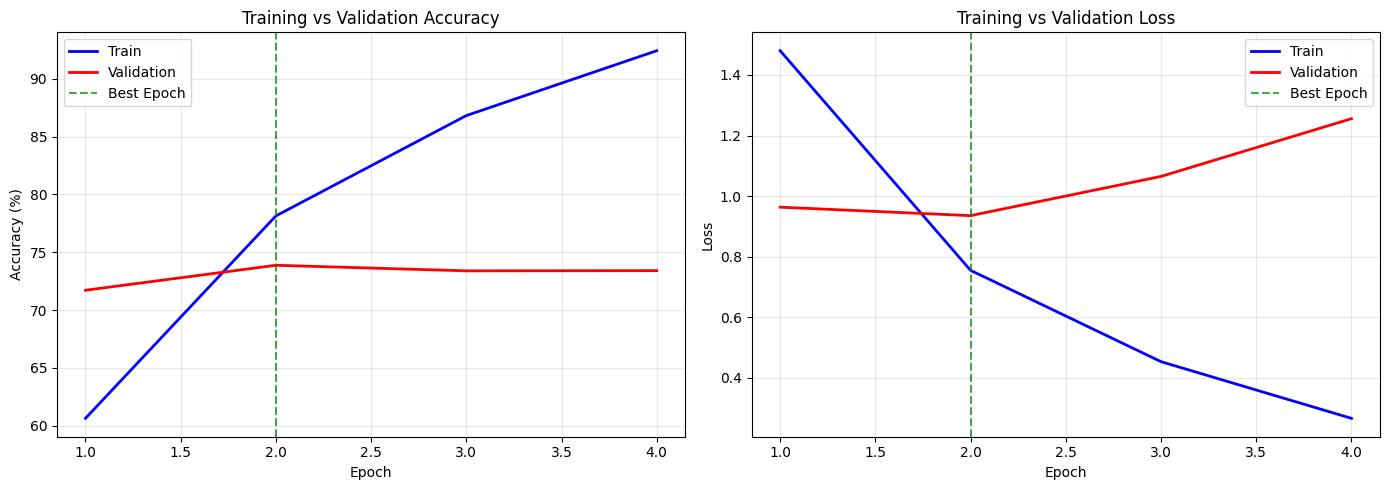


Test Set Evaluation
--------------------------------------------------


Testing: 100%|██████████| 1879/1879 [00:11<00:00, 170.00it/s]



FINAL TEST METRICS
Test Accuracy:  74.08%
Test Loss:      0.9295
Macro F1:       0.6528
Weighted F1:    0.7405

Generating confusion matrix...


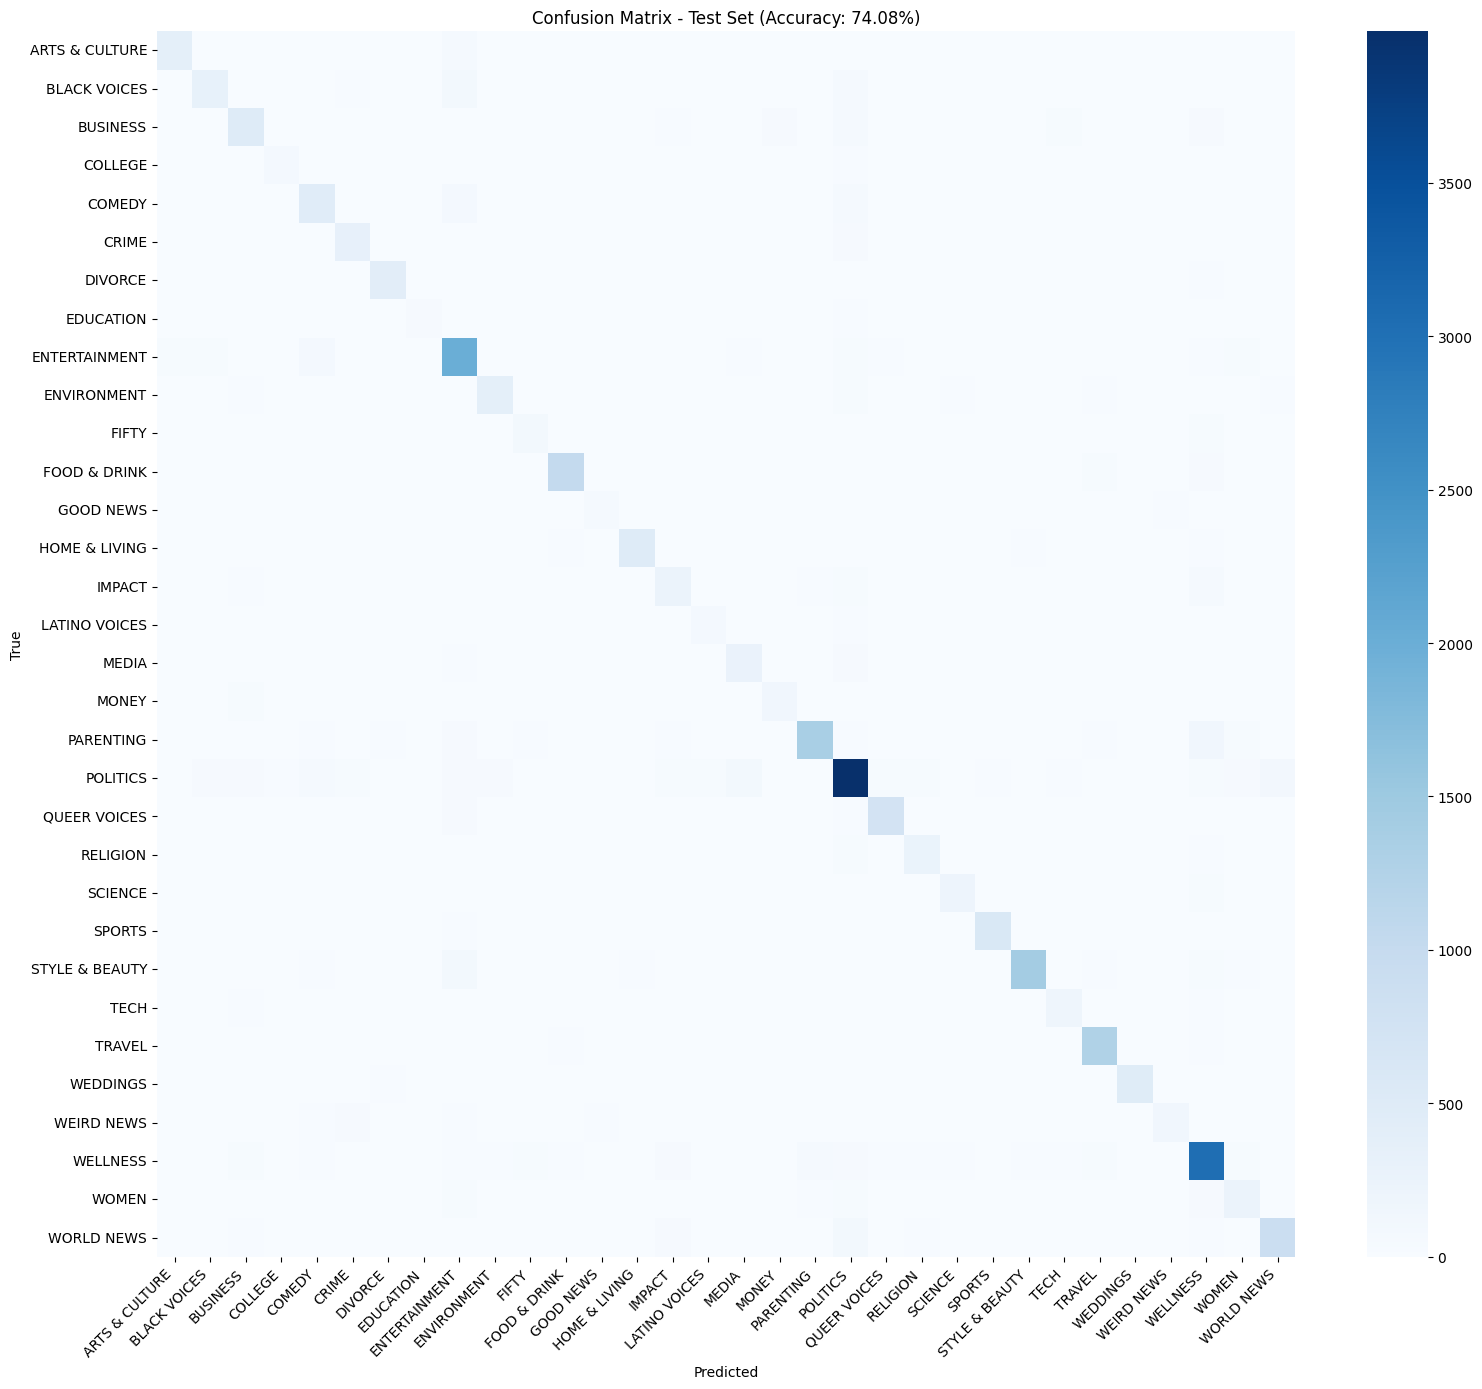


Per-Class Performance:
--------------------------------------------------------------------------------
                precision    recall  f1-score   support

ARTS & CULTURE     0.6511    0.6489    0.6500       581
  BLACK VOICES     0.6054    0.4661    0.5267       678
      BUSINESS     0.6074    0.5685    0.5873       890
       COLLEGE     0.5376    0.5407    0.5391       172
        COMEDY     0.5568    0.6021    0.5785       774
         CRIME     0.6085    0.6706    0.6381       510
       DIVORCE     0.8392    0.8327    0.8359       514
     EDUCATION     0.7045    0.4133    0.5210       150
 ENTERTAINMENT     0.7152    0.8343    0.7702      2408
   ENVIRONMENT     0.6515    0.6548    0.6532       591
         FIFTY     0.4057    0.4714    0.4361       210
  FOOD & DRINK     0.8815    0.8229    0.8512      1248
     GOOD NEWS     0.5081    0.3000    0.3772       210
 HOME & LIVING     0.8489    0.8000    0.8237       625
        IMPACT     0.4182    0.4691    0.4422       51

In [6]:
# ============================================
# A.2: MODEL SELECTION AND RETRAINING
# ============================================
# Final model: DistilBERT fine-tuned for sequence classification
# Selected based on Milestone 2 results: 72.2% accuracy vs 61.7% baseline
#
# Improvements over M2:
#   - Early stopping on val_loss (not accuracy) to prevent overfitting
#   - Increased weight_decay for regularization
#   - Back-translation augmentation for better generalization

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import numpy as np
import pickle
from datasets import load_from_disk

print("=" * 70)
print("A.2: MODEL SELECTION AND RETRAINING")
print("=" * 70)

# ============================================
# TRAINING CONFIGURATION
# ============================================

TRAIN_CONFIG = {
    'batch_size': 16,
    'learning_rate': 2e-5,
    'epochs': 5,
    'warmup_ratio': 0.1,
    'weight_decay': 0.05,       # Increased from 0.01 for regularization
    'max_grad_norm': 1.0,
    'patience': 2,              # Early stopping patience (on val_loss)
}

print("\nTraining Configuration:")
for k, v in TRAIN_CONFIG.items():
    print(f"  {k}: {v}")

# ============================================
# LOAD PREPROCESSED DATA
# ============================================
print("\n[1/6] Loading preprocessed dataset...")

# Load from the new pipeline output
processed_datasets = load_from_disk("huffpost_final_processed")
train_ds = processed_datasets['train']
val_ds = processed_datasets['validation']
test_ds = processed_datasets['test']

# Load label encoder and class weights
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

class_weights = np.load('class_weights.npy')
num_labels = len(le.classes_)

print(f"  Train: {len(train_ds):,} samples")
print(f"  Val:   {len(val_ds):,} samples")
print(f"  Test:  {len(test_ds):,} samples")
print(f"  Classes: {num_labels}")

# ============================================
# TOKENIZATION (if not already done)
# ============================================
print("\n[2/6] Preparing data for PyTorch...")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Check if already tokenized
if 'input_ids' not in train_ds.column_names:
    print("  Tokenizing datasets...")
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    train_ds = train_ds.map(tokenize_function, batched=True, batch_size=1000)
    val_ds = val_ds.map(tokenize_function, batched=True, batch_size=1000)
    test_ds = test_ds.map(tokenize_function, batched=True, batch_size=1000)
else:
    print("  Datasets already tokenized")

# Set format for PyTorch
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print(f"  Format set to PyTorch tensors")

# ============================================
# MODEL SETUP
# ============================================
print("\n[3/6] Loading pretrained DistilBERT model...")

# Device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"  Device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    problem_type="single_label_classification"
)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# ============================================
# TRAINING SETUP
# ============================================
print("\n[4/6] Configuring optimizer and scheduler...")

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=TRAIN_CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=TRAIN_CONFIG['batch_size'])
test_loader = DataLoader(test_ds, batch_size=TRAIN_CONFIG['batch_size'])

# Loss function (no class weights - they hurt performance in M2 experiments)
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay
optimizer = AdamW(
    model.parameters(),
    lr=TRAIN_CONFIG['learning_rate'],
    weight_decay=TRAIN_CONFIG['weight_decay']
)

# Learning rate scheduler with linear warmup
total_steps = len(train_loader) * TRAIN_CONFIG['epochs']
warmup_steps = int(total_steps * TRAIN_CONFIG['warmup_ratio'])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"  Total training steps: {total_steps:,}")
print(f"  Warmup steps: {warmup_steps:,}")
print(f"  Train batches/epoch: {len(train_loader):,}")
print(f"  Val batches/epoch: {len(val_loader):,}")

# ============================================
# TRAINING FUNCTIONS
# ============================================

def train_epoch(model, loader, criterion, optimizer, scheduler, device, max_grad_norm):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training")
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'acc': f'{100*correct/total:.1f}%'})

    return total_loss / len(loader), 100 * correct / total


def evaluate(model, loader, criterion, device):
    """Evaluate on validation/test set."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(loader), 100 * correct / total

# ============================================
# TRAINING LOOP (with early stopping on val_loss)
# ============================================
print("\n[5/6] Starting training...")
print("=" * 70)
print(f"Early stopping: patience={TRAIN_CONFIG['patience']} epochs (based on val_loss)")

start_time = time.time()
best_val_acc = 0
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0

# Track history for plotting
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(TRAIN_CONFIG['epochs']):
    print(f"\nEpoch {epoch+1}/{TRAIN_CONFIG['epochs']}:")

    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scheduler,
        device, TRAIN_CONFIG['max_grad_norm']
    )
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"  Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.3f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Train-Val Gap: {train_acc - val_acc:.2f}%")

    # Save best model based on VALIDATION LOSS (not accuracy)
    if val_loss < best_val_loss:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0  # Reset patience counter
        model.save_pretrained('best_distilbert_final')
        tokenizer.save_pretrained('best_distilbert_final')
        print(f"  >> New best model saved! (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  >> No improvement. Patience: {patience_counter}/{TRAIN_CONFIG['patience']}")
        if patience_counter >= TRAIN_CONFIG['patience']:
            print(f"\n  >> Early stopping triggered at epoch {epoch+1}")
            break

training_time = time.time() - start_time

print("\n" + "=" * 70)
print("TRAINING COMPLETE")
print("=" * 70)
print(f"Training time: {training_time:.2f}s ({training_time/60:.1f} min)")
print(f"Best epoch: {best_epoch + 1}")
print(f"Best val loss: {best_val_loss:.4f}")
print(f"Best val accuracy: {best_val_acc:.2f}%")
print(f"Stopped at epoch: {len(history['train_loss'])}")

# Overfitting analysis
train_acc_at_best = history['train_acc'][best_epoch]
val_acc_at_best = history['val_acc'][best_epoch]
overfitting_gap = train_acc_at_best - val_acc_at_best

print(f"\nOverfitting Analysis:")
print(f"  Train acc at best: {train_acc_at_best:.2f}%")
print(f"  Val acc at best:   {val_acc_at_best:.2f}%")
print(f"  Gap: {overfitting_gap:.2f}%")

# ============================================
# A.3: EVALUATION AND VISUALIZATION
# ============================================
print("\n" + "=" * 70)
print("A.3: EVALUATION AND VISUALIZATION")
print("=" * 70)

# ============================================
# TRAINING CURVES
# ============================================
print("\n[6/6] Generating evaluation plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history['train_acc'])+1)

# Accuracy curves
axes[0].plot(epochs_range, history['train_acc'],
             'b-', linewidth=2, label='Train')
axes[0].plot(epochs_range, history['val_acc'],
             'r-', linewidth=2, label='Validation')
axes[0].axvline(x=best_epoch+1, color='g', linestyle='--', alpha=0.7, label='Best Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Training vs Validation Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss curves
axes[1].plot(epochs_range, history['train_loss'],
             'b-', linewidth=2, label='Train')
axes[1].plot(epochs_range, history['val_loss'],
             'r-', linewidth=2, label='Validation')
axes[1].axvline(x=best_epoch+1, color='g', linestyle='--', alpha=0.7, label='Best Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training vs Validation Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================
# TEST SET EVALUATION
# ============================================
print("\nTest Set Evaluation")
print("-" * 50)

# Load best model
model = AutoModelForSequenceClassification.from_pretrained('best_distilbert_final').to(device)
model.eval()

all_preds = []
all_labels = []
test_loss_total = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = criterion(logits, labels)
        test_loss_total += loss.item()

        _, predicted = torch.max(logits, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss_total / len(test_loader)
test_acc = 100 * sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

# Calculate metrics
macro_f1 = f1_score(all_labels, all_preds, average='macro')
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\n{'='*50}")
print("FINAL TEST METRICS")
print(f"{'='*50}")
print(f"Test Accuracy:  {test_acc:.2f}%")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Macro F1:       {macro_f1:.4f}")
print(f"Weighted F1:    {weighted_f1:.4f}")

# ============================================
# CONFUSION MATRIX
# ============================================
print("\nGenerating confusion matrix...")

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Test Set (Accuracy: {test_acc:.2f}%)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================
# PER-CLASS METRICS
# ============================================
print("\nPer-Class Performance:")
print("-" * 80)

# Get category names
y_pred_categories = le.inverse_transform(all_preds)
y_true_categories = le.inverse_transform(all_labels)

print(classification_report(y_true_categories, y_pred_categories,
                          target_names=le.classes_, digits=4))

# ============================================
# COMPARISON WITH MILESTONE 2
# ============================================
print("\n" + "=" * 70)
print("COMPARISON WITH PREVIOUS MODELS")
print("=" * 70)

# Milestone 2 results (without improvements)
m2_results = {
    'Baseline (Embedding+Pool)': {'acc': 61.68, 'macro_f1': 0.4663, 'time': '82s'},
    'Custom TextCNN': {'acc': 61.85, 'macro_f1': 0.5027, 'time': '801s'},
    'DistilBERT (M2)': {'acc': 72.24, 'macro_f1': 0.6319, 'time': '1292s'},
}

print(f"\n{'Model':<35} {'Accuracy':<12} {'Macro F1':<12} {'Time':<10}")
print("-" * 70)
for model_name, metrics in m2_results.items():
    print(f"{model_name:<35} {metrics['acc']:<12.2f} {metrics['macro_f1']:<12.4f} {metrics['time']:<10}")
print(f"{'DistilBERT + BackTrans + EarlySto':<35} {test_acc:<12.2f} {macro_f1:<12.4f} {f'{training_time:.0f}s':<10}")

improvement = test_acc - m2_results['DistilBERT (M2)']['acc']
print(f"\nImprovement over M2 DistilBERT: {improvement:+.2f}%")
print(f"Overfitting gap at best epoch: {overfitting_gap:.2f}% (target: <15%)")